# 多クラス分類



この章では、一つ前の二値分類を拡張し、多クラス分類について説明する。

多クラス分類とは、分類タスクにおいて、2つ以上のクラスに対して予測を行うことである。

二項分類が2つのクラス（例：正/負、0/1）に対する予測だけを行うのに対し、
多クラス分類は3つ以上の異なるクラスに対して予測を行う。手書き文字認識や画像分類など、多くの応用例がある。

例えば手書き文字の画像を与えて、画像の中で描かれている数字が0~9のいずれかを判定する場合はクラスの数は１０になり、
一般の写真を見せて写っているものが何か分類する際には、分類したい項目の数を指定する必要がある。
したがって、クラスの数については一般に問題ごとに変わり得る。そこで、以下では、できるだけクラスの数を$N$と一般化して議論することにしよう。


## "多クラス"の扱い方

まずは、特定のデータについて、どのように"多クラス"を扱うかを考えてみよう。

- **入力**: $D$次元のベクトル$\boldsymbol{x} \in \mathbb{R}^D$とする。例えば画像データならピクセル値を並べたベクトルなどになる。
- **クラス(またはカテゴリやラベル)**: 分類の候補。集合であることを明示して$\mathcal{C} = \{C_1,C_2,...,C_K\}$と書くことにする。$K$は分類先のクラスの数。
    >例えば果物について分類する場合、$\mathcal{C}=\{ \mathrm{りんご},\mathrm{みかん},\mathrm{バナナ},...\}$といったイメージ。
- **出力**: $K$次元のベクトル$\hat{\boldsymbol{y}}$とする。$K$個のクラスそれぞれに対応する要素が、そのクラスに属する確率を表す。
    >例えば、$K=3$の場合、$\boldsymbol{y}=(0.2, 0.5, 0.3)$というベクトルは、3つのクラスそれぞれに対応する要素が、それぞれ0.2, 0.5, 0.3という確率を表す。この場合、0.5が最も大きいので、このデータは2番目のクラスに属すると予測される。

以降では、データの真の分類を$y$と書き、何らかのモデルによる分類の予測には$\hat{\boldsymbol{y}}$という記号を使うことにする。

## 線形多クラス分類　

線形二値分類を拡張して多クラス分類を考えてみよう。
多クラス分類では、各クラスに対してスコアを計算し、その中で最も高いスコアを持つクラスを予測値とする。

$$
\hat{y} = \mathop{\rm argmax}\limits_{y \in \mathcal{C}} \boldsymbol{w}_y^T \boldsymbol{x} 
$$

ここで、各クラス$y$に対応する重みベクトルを$\boldsymbol{w}_y$とした。この式は、入力$\boldsymbol{x}$に対して、各クラスに対応する重みベクトルとの内積を計算し、最大となるクラスを予測するというものである。

線形二値分類の場合と同様、重み$\boldsymbol{w}_y$は、そのクラスに属するデータを正しく分類できるように学習(調整)する。


より具体的な手続きとしてよく用いられるのが、多クラスロジスティック回帰やsoftmax回帰などとも呼ばれる以下の方法である。

まず、softmax関数を以下のように定義しておこう:

$$
\text{softmax}(\boldsymbol{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}} \quad \text{for } i = 1, 2, ..., K
$$

つまり、$K$個の入力 (あるいはベクトル $\boldsymbol{z}$) を受取り、各要素が0から1の範囲にあり、全体で1になるような離散的な確率分布を出力する関数である。

なんのことはない、指数関数をとって正規化しているだけで以下のように簡単に実装もできる。
※本当は、オーバーフローの対策なども必要だが、ここでは省略した。

In [1]:
import numpy as np 
def softmax(z): #naiveな実装
    return np.exp(z) / np.sum(np.exp(z))

これに何らかのベクトルを入力して、出力をプロットしてみよう。

Text(0, 0.5, 'Probability for each class')

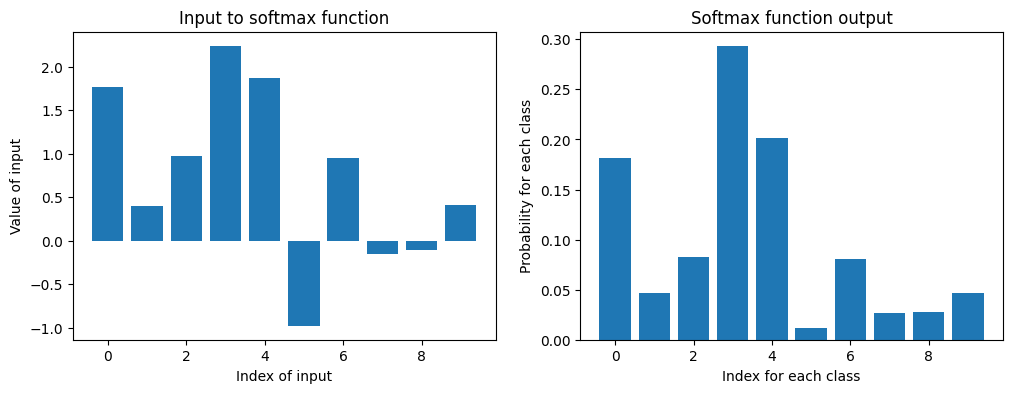

In [2]:
from matplotlib import pyplot as plt

np.random.seed(0)
z_in = np.random.randn(10)
z_out = softmax( z_in )

fig = plt.figure(figsize=(12,4))
axL = fig.add_subplot(1,2,1)
axR = fig.add_subplot(1,2,2)
axL.bar(np.arange(len(z_in)), z_in)
axL.set_title('Input to softmax function')
axL.set_xlabel('Index of input')
axL.set_ylabel('Value of input')
axR.bar(np.arange(len(z_out)), z_out)
axR.set_title('Softmax function output')
axR.set_xlabel('Index for each class')
axR.set_ylabel('Probability for each class')



0~9の手書き数字の画像データセット(MNIST)を用いて、ソフトマックス回帰を実装してみた。
※学習が効率的に進むよう、PyTorchを用いて線形層とソフトマックス関数を使った実装にしてある。

Epoch 1/10, Loss: 0.6569
Epoch 2/10, Loss: 0.3846
Epoch 3/10, Loss: 0.3614
Epoch 4/10, Loss: 0.3495
Epoch 5/10, Loss: 0.3370
Epoch 6/10, Loss: 0.3349
Epoch 7/10, Loss: 0.3266
Epoch 8/10, Loss: 0.3242
Epoch 9/10, Loss: 0.3219
Epoch 10/10, Loss: 0.3205
Test Accuracy: 87.94%


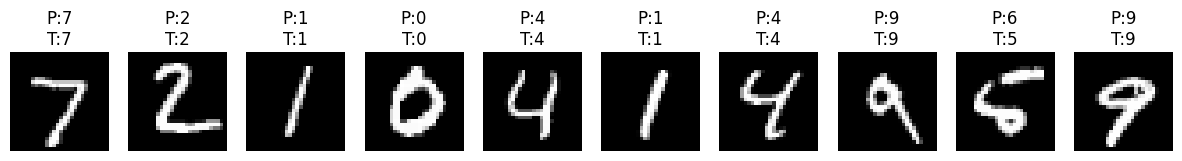

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. データセットの準備 (MNIST, 28x28 画像, 0~9 のラベル)
transform = transforms.Compose([transforms.ToTensor(),  # 画像をTensor化
                                transforms.Normalize((0.5,), (0.5,))])  # 正規化

trainset = torchvision.datasets.MNIST(root="./data", train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root="./data", train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# 2. Softmax回帰モデル (線形層のみ)
class SoftmaxRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(28*28, 10)  # 784次元 → 10クラス

    def forward(self, x):
        x = x.view(-1, 28*28)  # (batch, 1, 28, 28) → (batch, 784)
        return self.linear(x)  # Softmaxは損失関数に含まれる

model = SoftmaxRegression()

# 3. 損失関数と最適化手法
criterion = nn.CrossEntropyLoss()  # Softmax + CrossEntropy
optimizer = optim.SGD(model.parameters(), lr=0.1)

# 4. 学習ループ
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")

# 5. テスト精度の評価
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 6. いくつかのテストデータで予測を表示
dataiter = iter(testloader)
images, labels = next(dataiter)

# モデルの予測
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# 最初の10枚を表示
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(f"P:{predicted[i].item()}\nT:{labels[i].item()}")
    axes[i].axis("off")
plt.show()


### **$\clubsuit$ コードでやっていることの解説**

この箇所は、ニューラルネットワークの章の学習後に読むと理解が深まるように思う。

上の実装では、PyTorchの`nn.Linear`クラスを用いて線形変換を行い、その後に`nn.Softmax`クラスを用いてソフトマックス関数を適用している。
内部的にやっていることをもう少し式で書き下してみよう。

1. まず入力画像は、適当な前処理を行った後、1次元のベクトルに変換されているとする。
   例えば、28x28ピクセルのグレースケール画像なら、784次元のベクトルになる。
   これを$\boldsymbol{x} \in \mathbb{R}^{784}$と書くことにする。

   実際には、画像が複数あるので$\boldsymbol{x}^{(i)}$と$i$番目の画像を表すことにする。

2. 次に、線形変換を行う。PyTorchの`nn.Linear`クラスは、重み行列$\boldsymbol{W} \in \mathbb{R}^{K \times D}$とバイアスベクトル$\boldsymbol{b} \in \mathbb{R}^{K}$を持っており、入力$\boldsymbol{x}^{(i)}$に対して以下のような線形変換を行う。

   $$
   \boldsymbol{z}^{(i)} = \boldsymbol{W} \boldsymbol{x}^{(i)} + \boldsymbol{b}
   $$
   
   ここで、$K$はクラスの数（例えば、手書き数字なら10）、$D$は入力ベクトルの次元数（例えば、784）である。

3. 最後に、ソフトマックス関数を適用して、各クラスに対する確率を計算する。

   $$
   \hat{\boldsymbol{y}}^{(i)} = \text{softmax}(\boldsymbol{z}^{(i)})
   $$

   これにより、$\hat{\boldsymbol{y}}^{(i)}$は各クラスに対する確率を表すベクトルとなる。

4. 学習の際には、交差エントロピー損失関数を用いて、予測$\hat{\boldsymbol{y}}^{(i)}$と真のラベル$\boldsymbol{y}^{(i)}$との誤差を計算し、その誤差を最小化するように重み$\boldsymbol{W}$とバイアス$\boldsymbol{b}$を更新する。

    $$
      \mathcal{L} = -\sum_{i=1}^{N} \sum_{k=1}^{K} y_k^{(i)} \log(\hat{y}_k^{(i)})
    $$

    ここで、$N$はデータの総数、$y_k^{(i)}$は$i$番目のデータがクラス$k$に属する場合に1、それ以外の場合に0となる真のラベルである。$y_k^{(i)} = (0, 0, 1, 0, ..., 0)^T$のようなone-hotベクトルで表すことができる。

5. 各学習ステップで、ミニバッチのデータに対して上記の損失関数を計算し、勾配降下法を用いてパラメータを更新した。
   ミニバッチとは、学習や推論を効率よく行うために、データセットを小さなグループ（バッチ）に分割して処理する手法で、上では訓練データのバッチサイズを64に設定している。